# Desafio 4 - PFSP NEH - Dupla 09

**Integrantes:**

* Lucas Hideki Takeuchi Okamura NUSP: 9274315

* Thales Arantes Kerche Nunes NUSP: 10769372

**Objetivo**

* Programar o algoritmo heurístico NEH, que busca minimizar o makespan em um flow shop com m máquinas

**Descrição**

O código roda o algoritmo de NEH, outro método para resolver o problema
de máquinas em série. O algoritmo está explicitado no artigo "A Heuristic 
Algorithm for the m-Machine, n-Job Flow-shop Sequencing Problem", 1983, por 
Nawaz, Muhammad; Jr, E Emory Enscore; Ham, Inyong. Resumidamente, tem-se 
os passos abaixo:

	* Passo 1: Ordenar a lista de jobs em ordem decrescente do tempo total de processamento;

	* Passo 2: Retire os dois primeiros da lista ordenada e crie uma nova lista, teste as duas permutações, escolha a
    permutação com menor makespan;

	* Passo 3: Retire o próximo job da lista ordenada, teste em todas as posições da nova lista, escolha a inserção
    com menor makespan;

	* Passo 4: Repita o passo 3 até esvaziar a lista ordenada; a nova lista resultante será a solução do problema

In [1]:
import xlwings as xw
import numpy as np

## 1. Definindo a Class Job

In [2]:
class Job:
    def __init__(self,i,p):
        self.i=i     # número do job, pela ordem de chegada
        self.p=p     # processing times [p1,p2]
        self.C=[]     # completion times [c1,c2]
        self.psum = np.sum(self.p)     # sum of values of p

## 2. Definindo Funções

**Função para o cálculo dos tempos de conclusão dos jobs em cada uma das m máquinas**

$p_{(j)k}:$ processing time do job da posição j na máquina k

$c_{(j)k}:$ completion time do job da posição j na máquina k

$c_{(1)1} = p_{(1)1}$

$c_{(1)k}=c_{(1),k−1}+p_{(1)k}$, onde    $k=2,...,m$

$c_{(j)1}=c_{(j−1)1}+p_{(j)1}$, onde $j=2,...,n$

$c_{(j)k}=max\left\{{c_{(j),k−1},c_{(j−1)k}}\right\} +p_{(j)k}$, onde $j=2,...,n$ e $k=2,...,m$

In [3]:
def calcCmax(m,jobs):     # esta função calcula os tempos de conclusão dos jobs nas m máquinas
    n=len(jobs)
    c=[[0 for i in range(m)] for j in range(n)]
    p=[job.p for job in jobs]
    
    # primeiro job
    c[0][0]=p[0][0]     # primeira máquina
    for k in range(1,m):     # próximas máquinas
        c[0][k]=c[0][k-1]+p[0][k]
        
    # próximos jobs
    for j in range(1,n):
        c[j][0]=c[j-1][0]+p[j][0]     # primeira máquina
        for k in range(1,m):     # próximas máquinas
            c[j][k]=max(c[j][k-1],c[j-1][k])+p[j][k]
            
    j=0
    for job in jobs:
        job.C=c[j]
        j+=1
    
    return c[-1][-1]

**Entrada de Dados**

In [4]:
def leInst(i):
    plan = wb1.sheets[i]
    n=int(plan.range('B6').value)
    m=int(plan.range('B5').value)
    tab=plan.range('B11').expand('table').value
    jobs=[]
    for j in range(n):
        p=tab[j]
        jobs.append(Job(j,p))
        
    print()
    print('#','p')
    for job in jobs:
        print(job.i, job.p)
    
    return jobs, m, n

**Saída de resultados**

In [5]:
def gravaSched(i,jobs,Cmax):
    n=len(jobs)
    tab=[]
    for job in jobs:
        a=[job.i+1]+job.p+job.C
        tab.append(a)

    if i==0:
        plan=wb2.sheets[0]
        plan.name='I(1)'
    else:
        plan=wb2.sheets.add('I('+str(i+1)+')',after=i)
        
    plan.range('A5').value=['m',2]
    plan.range('A6').value=['n',n]
    plan.range('E5').value=['Cmax',Cmax]
    plan.range('A10').value=['#','p1','p2','p3','p4','p5','C1','C2','C3','C4','C5']
    plan.range('A11').value=tab

    print()
    print('#','p','C')
    for job in jobs:
        print(job.i, job.p, job.C)
    print('Cmax:',Cmax)

**Algoritmo NEH**

In [6]:
def schedNEH(jobs, m):
    jobs.sort(key = lambda job: job.psum, reverse = True)
    n = len(jobs)
    
    # Realizando a primeira iteração
    jobsNEH1 = [jobs[0], jobs[1]]
    Cmax1 = calcCmax(m, jobsNEH1)
    
    jobsNEH2 = [jobs[1], jobs[0]]
    Cmax2 = calcCmax(m, jobsNEH2)
    
    if Cmax1 < Cmax2:
        jobsNEH = jobsNEH1
    else:
        jobsNEH = jobsNEH2
    
    for i in range(2, n):
        bestCmax = float('inf')
        for j in range(i+1):
            NEHcopy = jobsNEH[:]
            NEHcopy.insert(j, jobs[i])
            Cmax = calcCmax(m, NEHcopy)
            if Cmax < bestCmax:
                bestCmax = Cmax
                bestNEH = NEHcopy
        jobsNEH = bestNEH
                
    bestCmax = calcCmax(m, jobsNEH)
    
    return jobsNEH, bestCmax

## 3. Testando com dados do Excel

In [7]:
wb1 = xw.Book('xl09 2 A PFSP Cmax NEH.xlsx')
wb2 = xw.Book()
I = wb1.sheets.count     # número de instância é igual ao número de planilhas na pasta

for i in range(I):
    print()
    print(i+1)
    jobs, m, n = leInst(i)
    jobs, Cmax=schedNEH(jobs, m)
    gravaSched(i,jobs,Cmax)
    
wb2.save('xl09 2 A PFSP Cmax NEH.xlsx')


1

# p
0 [58.0, 60.0, 88.0, 14.0, 46.0]
1 [34.0, 33.0, 17.0, 67.0, 15.0]
2 [54.0, 25.0, 93.0, 60.0, 2.0]
3 [19.0, 84.0, 25.0, 47.0, 8.0]
4 [24.0, 45.0, 25.0, 16.0, 11.0]
5 [21.0, 69.0, 93.0, 22.0, 71.0]
6 [64.0, 43.0, 48.0, 83.0, 39.0]
7 [37.0, 43.0, 18.0, 46.0, 13.0]
8 [26.0, 57.0, 34.0, 5.0, 18.0]
9 [82.0, 14.0, 98.0, 27.0, 14.0]
10 [84.0, 43.0, 96.0, 67.0, 81.0]
11 [75.0, 87.0, 45.0, 11.0, 44.0]
12 [73.0, 27.0, 32.0, 9.0, 79.0]
13 [24.0, 94.0, 39.0, 23.0, 95.0]
14 [49.0, 54.0, 8.0, 70.0, 97.0]
15 [27.0, 61.0, 55.0, 87.0, 35.0]
16 [98.0, 8.0, 90.0, 15.0, 55.0]
17 [51.0, 93.0, 80.0, 86.0, 35.0]
18 [83.0, 87.0, 25.0, 94.0, 80.0]
19 [12.0, 80.0, 12.0, 49.0, 38.0]

# p C
19 [12.0, 80.0, 12.0, 49.0, 38.0] [12.0, 92.0, 104.0, 153.0, 191.0]
2 [54.0, 25.0, 93.0, 60.0, 2.0] [66.0, 117.0, 210.0, 270.0, 272.0]
13 [24.0, 94.0, 39.0, 23.0, 95.0] [90.0, 211.0, 250.0, 293.0, 388.0]
6 [64.0, 43.0, 48.0, 83.0, 39.0] [154.0, 254.0, 302.0, 385.0, 427.0]
5 [21.0, 69.0, 93.0, 22.0, 71.0] [175.0, 323.0, 


# p C
15 [8.0, 21.0, 4.0, 38.0, 35.0] [8.0, 29.0, 33.0, 71.0, 106.0]
9 [6.0, 24.0, 25.0, 76.0, 65.0] [14.0, 53.0, 78.0, 154.0, 219.0]
3 [13.0, 15.0, 46.0, 59.0, 52.0] [27.0, 68.0, 124.0, 213.0, 271.0]
4 [50.0, 48.0, 7.0, 16.0, 47.0] [77.0, 125.0, 132.0, 229.0, 318.0]
0 [46.0, 28.0, 44.0, 49.0, 38.0] [123.0, 153.0, 197.0, 278.0, 356.0]
6 [27.0, 91.0, 10.0, 95.0, 11.0] [150.0, 244.0, 254.0, 373.0, 384.0]
14 [30.0, 43.0, 1.0, 5.0, 8.0] [180.0, 287.0, 288.0, 378.0, 392.0]
19 [44.0, 30.0, 61.0, 99.0, 17.0] [224.0, 317.0, 378.0, 477.0, 494.0]
13 [32.0, 52.0, 67.0, 71.0, 29.0] [256.0, 369.0, 445.0, 548.0, 577.0]
5 [82.0, 7.0, 45.0, 53.0, 74.0] [338.0, 376.0, 490.0, 601.0, 675.0]
7 [54.0, 21.0, 60.0, 95.0, 59.0] [392.0, 413.0, 550.0, 696.0, 755.0]
17 [54.0, 75.0, 74.0, 61.0, 78.0] [446.0, 521.0, 624.0, 757.0, 835.0]
11 [66.0, 79.0, 16.0, 80.0, 91.0] [512.0, 600.0, 640.0, 837.0, 928.0]
18 [92.0, 83.0, 82.0, 59.0, 83.0] [604.0, 687.0, 769.0, 896.0, 1011.0]
10 [84.0, 75.0, 82.0, 84.0, 39.0] [688


# p C
5 [4.0, 24.0, 7.0, 79.0, 41.0] [4.0, 28.0, 35.0, 114.0, 155.0]
12 [18.0, 9.0, 17.0, 41.0, 38.0] [22.0, 37.0, 54.0, 155.0, 193.0]
16 [45.0, 22.0, 14.0, 94.0, 16.0] [67.0, 89.0, 103.0, 249.0, 265.0]
2 [26.0, 4.0, 65.0, 62.0, 59.0] [93.0, 97.0, 168.0, 311.0, 370.0]
10 [44.0, 62.0, 63.0, 80.0, 64.0] [137.0, 199.0, 262.0, 391.0, 455.0]
7 [52.0, 71.0, 71.0, 88.0, 87.0] [189.0, 270.0, 341.0, 479.0, 566.0]
9 [43.0, 17.0, 12.0, 77.0, 16.0] [232.0, 287.0, 353.0, 556.0, 582.0]
14 [16.0, 84.0, 21.0, 53.0, 88.0] [248.0, 371.0, 392.0, 609.0, 697.0]
17 [80.0, 5.0, 89.0, 28.0, 69.0] [328.0, 376.0, 481.0, 637.0, 766.0]
1 [69.0, 99.0, 84.0, 96.0, 95.0] [397.0, 496.0, 580.0, 733.0, 861.0]
19 [71.0, 71.0, 57.0, 35.0, 44.0] [468.0, 567.0, 637.0, 768.0, 905.0]
13 [91.0, 92.0, 13.0, 74.0, 80.0] [559.0, 659.0, 672.0, 842.0, 985.0]
11 [96.0, 49.0, 77.0, 71.0, 89.0] [655.0, 708.0, 785.0, 913.0, 1074.0]
0 [66.0, 73.0, 83.0, 96.0, 24.0] [721.0, 794.0, 877.0, 1009.0, 1098.0]
4 [55.0, 20.0, 45.0, 74.0, 31.0]

com_error: (-2147352567, 'Exceção.', (0, 'Microsoft Excel', 'Não é possível salvar esta pasta de trabalho com o mesmo nome de outra pasta de trabalho ou suplemento abertos. Escolha um nome diferente ou feche o documento aberto antes de salvá-lo.', 'xlmain11.chm', 0, -2146827284), None)

In [8]:
ps = [[16, 18, 12],
      [14, 10, 11],
      [13, 20, 15],
      [19, 15, 19],
      [15, 16, 16]]

jobs_test = []
n = len(ps)
m = len(ps[0])

for i in range(n):
    jobs_test.append(Job(i, ps[i]))
    
jobs_test, Cmax = schedNEH(jobs_test, m)

print('#','p','C')
for job in jobs_test:
    print(job.i, job.p, job.C)
print('Cmax:',Cmax)

# p C
2 [13, 20, 15] [13, 33, 48]
3 [19, 15, 19] [32, 48, 67]
4 [15, 16, 16] [47, 64, 83]
0 [16, 18, 12] [63, 82, 95]
1 [14, 10, 11] [77, 92, 106]
Cmax: 106


## 4. Comparação entre NEH e CDS

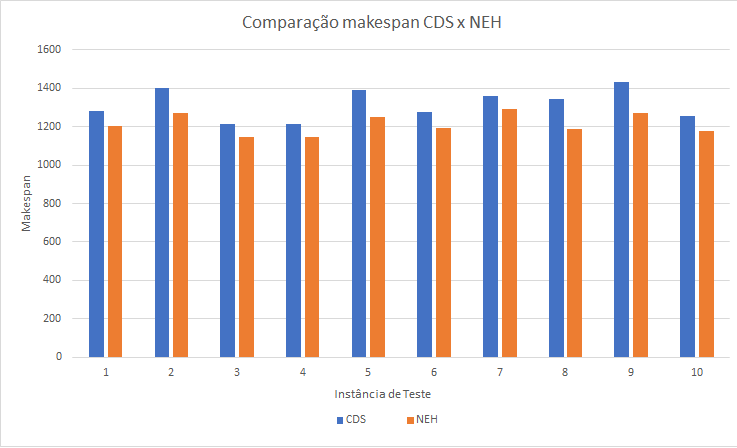